# 1. Library Import

In [1]:
import pandas as pd
from datetime import datetime

# Visulize
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Scrapping
import requests as rq
from bs4 import BeautifulSoup as bbs

# 2. Data Scrapping

In [2]:
def data_scrap():
    url = 'https://www.worldometers.info/coronavirus/'
    response = rq.get(url)
    data = bbs(response.text, 'html.parser')
    all_data = []
    column = []
    for k in data.findAll('table', {'id': 'main_table_countries_today'}):
        for i in k.findAll('tr'):
            temp = []
            for j in i.findAll('th')[:8]:
                column.append(j.text)
            for j in i.findAll('td')[:8]:
                j = j.text.strip().replace(',', '')
                if j:
                    try:
                        val = int(j)
                    except:
                        val = j
                else:
                    val = 0
                temp.append(val)
            if temp:
                all_data.append(temp)
    column_len = len(all_data[0])
    df = pd.DataFrame(all_data, columns=column[:column_len])
    df = df.groupby('Country,Other').first()
    df = df.drop(['World', 'Total:'], axis=0)

    return df

# 3. CSV Formation

In [3]:
def csv_form(df):
    data_dict = {}

    data_dict['total_case'] = df.TotalCases
    # Actual Data
    data_dict['ac_recover'] = df.TotalRecovered
    data_dict['ac_active'] = (df.ActiveCases-df['Serious,Critical'])
    data_dict['ac_critical'] = df['Serious,Critical']
    data_dict['ac_death'] = df.TotalDeaths

    # Country Wise Percentage
    data_dict['c_recover'] = data_dict['ac_recover']/df.TotalCases
    data_dict['c_active'] = data_dict['ac_active']/df.TotalCases
    data_dict['c_critical'] = data_dict['ac_critical']/df.TotalCases
    data_dict['c_death'] = data_dict['ac_death']/df.TotalCases

    total_recover = sum(df.TotalRecovered)
    total_active = sum(df.ActiveCases)
    total_death = sum(df.TotalDeaths)

    # Worldwide wise percentage
    data_dict['w_recover'] = df.TotalRecovered/total_recover
    data_dict['w_active'] = df.ActiveCases/total_active
    data_dict['w_death'] = df.TotalDeaths/total_death

    df = pd.concat(list(data_dict.values()), axis=1)
    df.columns = list(data_dict.keys())

    date = pd.DataFrame(
        df.shape[0]*[[datetime.now().strftime("%d %b,%Y")]], index=df.index.values, columns=['Date'])
    df = pd.concat([df, date], axis=1)

    return df

# 4. Data Load

In [4]:
def data_extract(threshold=None):
    try:
        df = data_scrap()
        df = csv_form(df)
        df.to_csv('Last_updated.csv')
    except:
        df = pd.read_csv('Last_updated.csv', index_col=0)
        for i in df.columns[:-1]:
            df[i] = pd.to_numeric(df[i])

    if threshold:
        df = df[df.total_case > threshold]

    return df

In [5]:
df = data_extract()

# 5. WordCloud

In [6]:
def show_wordcloud(main_data, save=True):
    stopwords = set(STOPWORDS)

    data = {i: j for i, j in zip(df.index, df.ac_active+df.ac_critical)}

    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=len(data),
        max_font_size=80,
        scale=3,
        random_state=200
    ).generate_from_frequencies(data).recolor(random_state=63008)

    plt.figure(figsize=(16, 8), facecolor='white', edgecolor='blue')
    plt.title('Active patient of COVID-19 Until ' +
              main_data.Date[0], fontsize=25)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    if save:
        plt.savefig('Image/Corona Stats Country wise.png')
    plt.show()

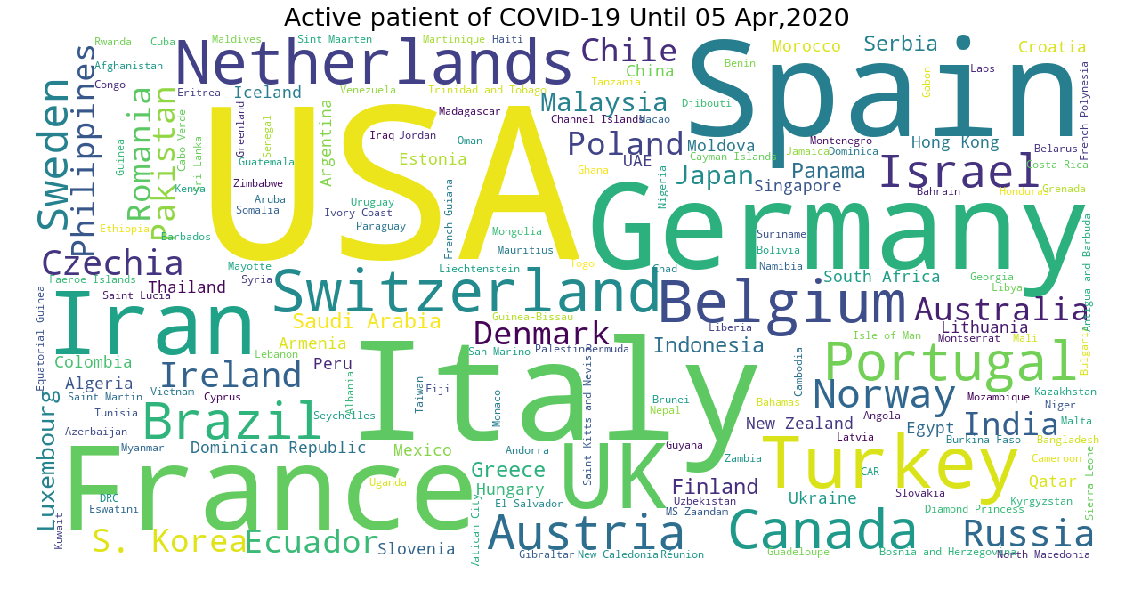

In [7]:
show_wordcloud(df)

# 6. Data Bar Plot Country Wise

In [8]:
def data_plot(main_data, row=10, save=True):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)

    new_data = main_data.sort_values(by=['total_case'], ascending=False)[:row]

    plt.bar(new_data.index.values, new_data.c_recover,
            color='limegreen', edgecolor='white', label='Recover')
    plt.bar(new_data.index.values, new_data.c_active, bottom=new_data.c_recover,
            color='darkorange', edgecolor='white', label='Active')
    plt.bar(new_data.index.values, new_data.c_critical, bottom=new_data.c_recover +
            new_data.c_active, color='crimson', edgecolor='white', label='Critical')
    plt.bar(new_data.index.values, new_data.c_death, bottom=new_data.c_recover +
            new_data.c_active+new_data.c_critical, color='darkred', edgecolor='white', label='Death')

    plt.xlabel("Country Name", fontsize=25)
    plt.ylabel('Patient Number in Percentage', fontsize=25)
    plt.title('Effect of COVID-19 Country Wise Until ' +
              new_data.Date[0], fontsize=25)

    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    xtickNames = ax.set_xticklabels(new_data.index.values)

    ax.legend(fontsize=15, loc='lower left')

    plt.setp(xtickNames, rotation=30, fontsize=15)
    if save:
        plt.savefig('Image/Corona.png')
    plt.show()

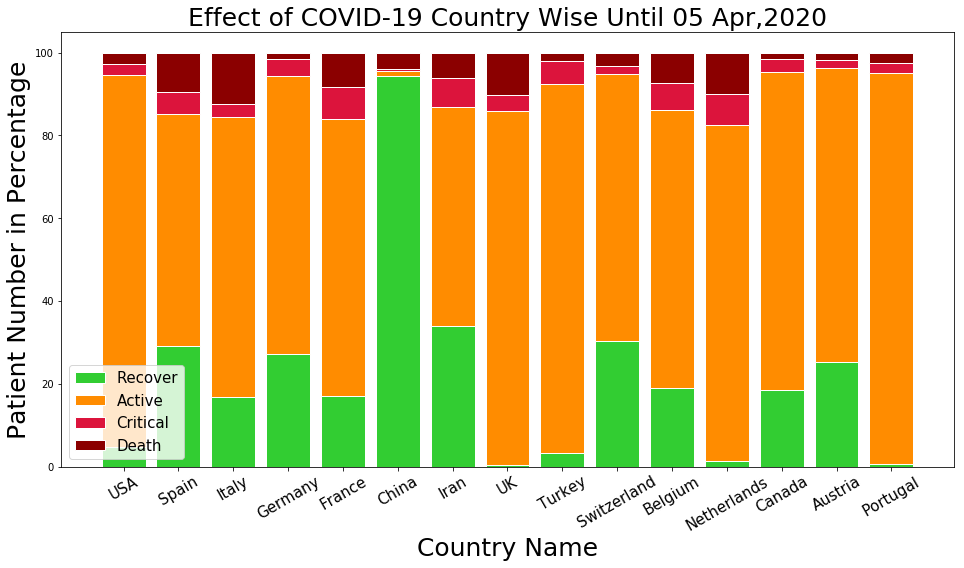

In [9]:
data_plot(df, 15)

# 7. Data Bar Plot World Wise

In [10]:
def data_stat(main_data, row=10, index=1, save=True):

    index -= 1
    column_val = [i for i in main_data.columns[5:-1] if i.find('cri') == -1]
    column_val = column_val[3:]+column_val[:3]

    name = column_val[index]
    if 'w_' in name:
        label = 'World Wise '+name.split('_')[-1].capitalize()
    else:
        label = 'Country Wise '+name.split('_')[-1].capitalize()

    new_data = main_data.sort_values(by=[name], ascending=False)

    new_data = new_data[:row]
    color = ['limegreen', 'darkorange', 'darkred']

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    plt.bar(new_data.index.values, new_data[name],
            color=color[index % 3], edgecolor='white', label=label)

    for i, j in enumerate(new_data[name]):
        ax.text(i, j, '{:.2f}%'.format(100*j),
                ha='center', va='bottom', fontsize=15)

    plt.xlabel("Country Name", fontsize=25)
    plt.ylabel('Patient Number in Percentage', fontsize=25)
    plt.title('COVID-19 {} Patient Until {}'.format(label,
                                                    new_data.Date[0]), fontsize=25)

    ax.set_yticklabels([])
    xtickNames = ax.set_xticklabels(new_data.index.values)

    ax.legend(fontsize=25, loc='upper right')

    plt.setp(xtickNames, rotation=30, fontsize=15)
    if save:
        plt.savefig('Image/'+' Corona '+label+'.png')

    plt.show()

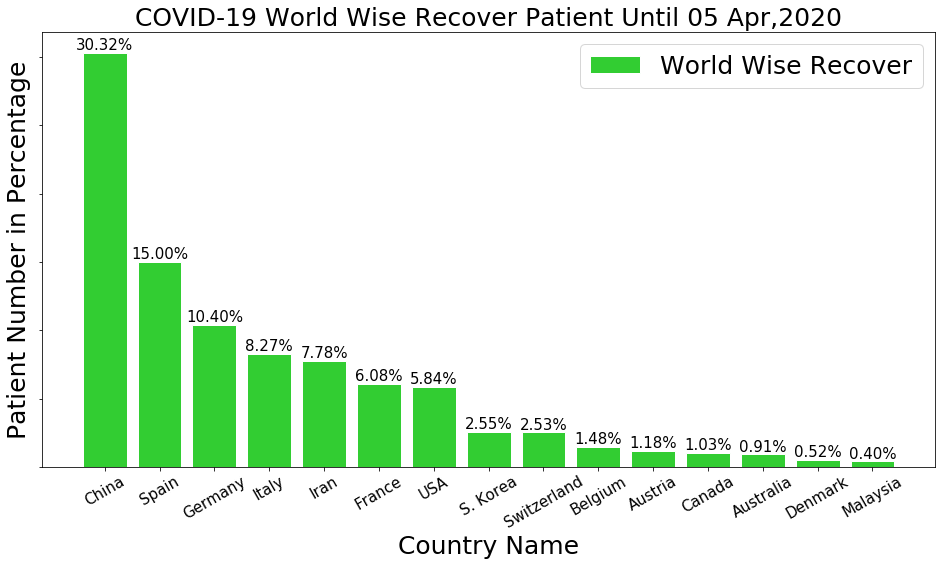

In [11]:
data_stat(df, row=15, index=1)

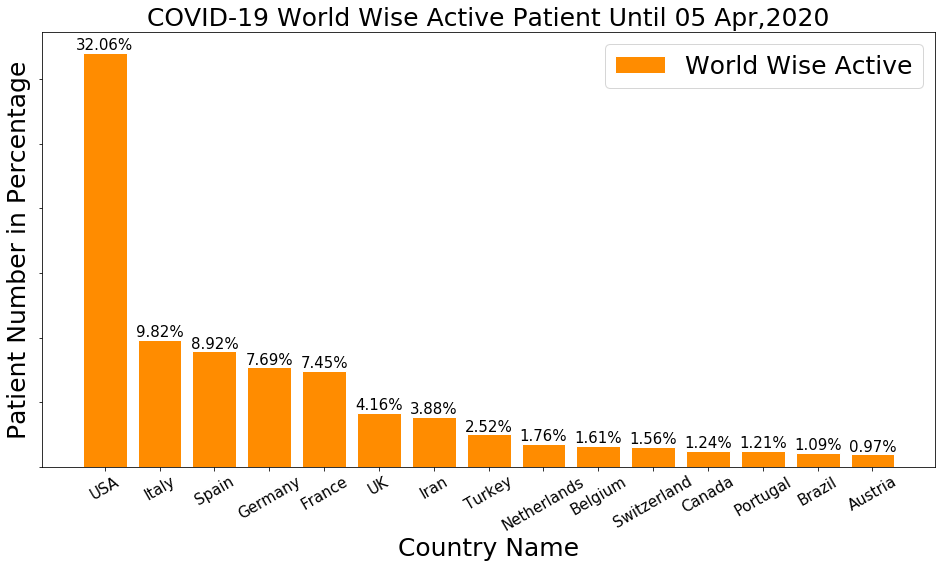

In [12]:
data_stat(df, row=15, index=2)

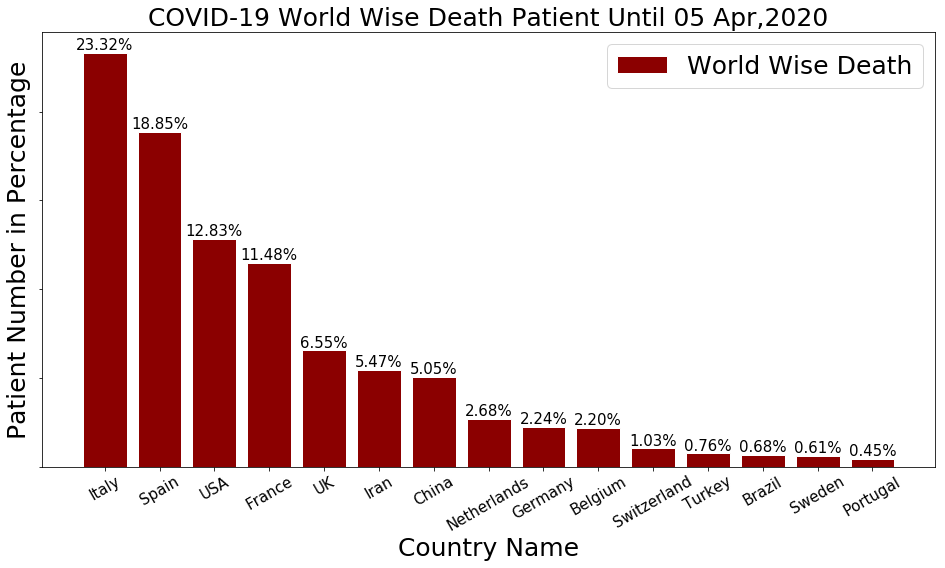

In [13]:
data_stat(df, row=15, index=3)